This notebook illustrates the basic usage of ThermoLIB to construct a 2D free energy profile from umbrella sampling simulations with 2D bias potentials using the WHAM methodology, including error estimation from the theory of the maximum likelihood estimator (MLE). We will also illustrate how we can project the 2D FES onto a 1D FEP.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import FreeEnergySurface2D, SimpleFreeEnergyProfile
from thermolib.thermodynamics.histogram import Histogram2D
from thermolib.tools import read_wham_input, decorrelate
from thermolib.thermodynamics.trajectory import ColVarReader

import numpy as np, matplotlib.pyplot as pp, time

from molmod.units import *

Define some file/path variables

In [3]:
prefix = 'basic_wham2d_' #will be added to all figures made in this notebook
fn_meta = 'data/HZSM5_link/wham_input_2D.txt' #location of the plumed metadata file containing all information of the umbrella sampling


# Basic WHAM application

First read the input trajectories and define the corresponding bias potentials of each biased simulations included in the metadata file. This is done using the ``read_wham_input`` routine in the code block below. Assuming a metadata file with lines in the form of:

    U14 2.85 -1.4 2000.0 1000.0

we interpret the metadata file using the keywords of the ``read_wham_input`` routine below as follows. A simulation was done with a 2D bias potential of type ``'Parabola2D'`` centered around ``Q01 = 2.85`` and ``Q02 = -1.4`` and with strengths ``kappa1 = 2000.0`` and ``kappa2 = 1000.0``  was given the label ``u14``. In the code block below, we define the unit of ``Q01`` and ``Q02`` both as ``au`` and those of ``kappa1`` and ``kappa2`` both as ``kjmol``. Furthermore, the corresponding trajectory of Q values during this simulation is stored in a file with path ``colvars/COLVAR_U14.dat`` relative to the metadata file directory. This file is then read by ``colvar_reader`` which is an instance of ``ColVarReader`` class and assumes the file to be a colvar file that stores the values of Q1 and in columns ``1`` and ``2`` respectively of a numpy file, both in units ``au``. Finally, the temperature is also read from the metadata file from the line (usually the first line) that starts with ``T``.

In [4]:
colvar_reader = ColVarReader([1,2], units=['au','au'], verbose=True)
temp, biasses, trajectories = read_wham_input(
    fn_meta, colvar_reader, 'colvars/colvar_%s.dat', 
    bias_potential='Parabola2D', q01_unit='au', q02_unit='au', kappa1_unit='kjmol', kappa2_unit='kjmol',
    verbose=True
)

Temperature set at 573.000000
Read 25001 trajectory samples for 2 CVs from data/HZSM5_link/colvars/colvar_U1.dat
Added bias Parabola2D (U1): K1=500 kjmol  q01=3.700e+00 au  K2=0 kjmol  q02=0.000e+00 au
Read 25001 trajectory samples for 2 CVs from data/HZSM5_link/colvars/colvar_U2.dat
Added bias Parabola2D (U2): K1=1000 kjmol  q01=3.500e+00 au  K2=0 kjmol  q02=0.000e+00 au
Read 25001 trajectory samples for 2 CVs from data/HZSM5_link/colvars/colvar_U3.dat
Added bias Parabola2D (U3): K1=1000 kjmol  q01=3.300e+00 au  K2=0 kjmol  q02=0.000e+00 au
Read 25001 trajectory samples for 2 CVs from data/HZSM5_link/colvars/colvar_U4.dat
Added bias Parabola2D (U4): K1=1000 kjmol  q01=3.100e+00 au  K2=0 kjmol  q02=0.000e+00 au
Read 25001 trajectory samples for 2 CVs from data/HZSM5_link/colvars/colvar_U5.dat
Added bias Parabola2D (U5): K1=1000 kjmol  q01=2.900e+00 au  K2=0 kjmol  q02=0.000e+00 au
Read 25001 trajectory samples for 2 CVs from data/HZSM5_link/colvars/colvar_U6.dat
Added bias Parabola2D (

The output for the ``read_wham_input`` routine shows (at least if the keyword ``verbose`` is set to ``True``) for each simulation from which file the CV data is read, how many samples are in that simulation as well as which bias potential is used. Next, we construct the 2D probability histogram on the given 2D CV grid (defined by ``bins1`` and ``bins2``) using the WHAM routine.

In [5]:
bins = [np.arange(1,4.025,0.025), np.arange(-2.5,0.025,0.025)]
hist = Histogram2D.from_wham(bins, trajectories, biasses, temp, verbosity='medium')

Initialization ...
Constructing individual histograms for each biased simulation ...
Computing bias on grid ...
Solving WHAM equations (SCF loop) ...
  SCF did not converge!

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.027s
  bias poten. : 00h 00m 02.039s
  solve scf   : 00h 00m 00.683s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 02.751s
---------------------------------------------------------------------


From the histogram, we can construct the corresponding free energy profile. We assume the profile contains a single transition state maximum within the Q-range of ``[-0.2,0.2]``, and a reactant state minimum for lower Q value and product state minimum for higher Q value. This is encoded in the class ``SimpleFreeEnergyProfile``. We then also define the energy reference by setting the reactant state minimum to zero and plot the resulting profile.

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values = self.fs[slicer].copy()
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1537: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = pp.colorbar(contourf, ax=ax, extend='both')


<Figure size 432x288 with 0 Axes>

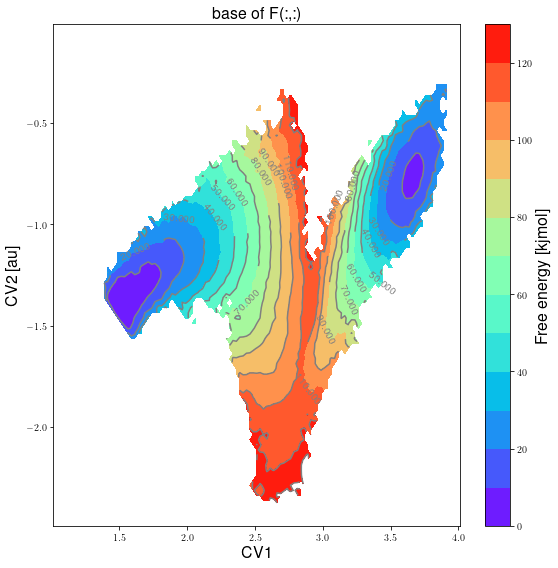

In [6]:
fes = FreeEnergySurface2D.from_histogram(hist, temp)
fes.set_ref(ref='min')
fes.plot(prefix+'fes.png', cmap='rainbow', flims=[0,130], ncolors=13)

# Projection onto 1D profile

## Along predefined direction

We now proceed to project the 2D FES in terms of CV1 and CV2 onto a 1D FEP in terms of a single Q, for which we can choose different forms. However, based on how the 2D FES looks like, the only choices for Q that makes sense (i.e. Q is able to distinguish between reactant, transition state and product), is projecting onto Q=CV1:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


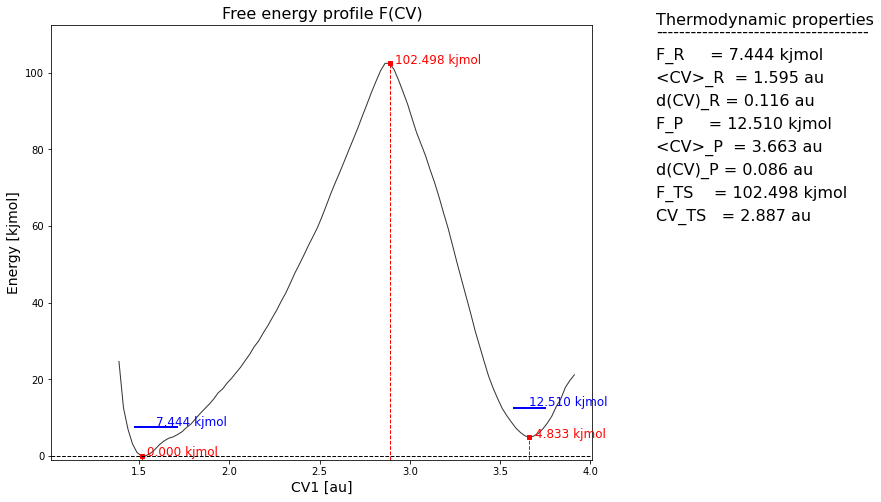

In [7]:
fep_cv1 = fes.project_cv1(return_class=SimpleFreeEnergyProfile)
fep_cv1.process_states(lims=[-np.inf,2.4,3.0,np.inf])
fep_cv1.set_ref(ref='r')
fep_cv1.plot(prefix+'fep_cv1.png')

## Along any custom direction

The above projection used a predefined direction of projection, i.e. onto CV1. However, we can define and perform a projection onto any preferred direction using the ``project_function`` routine of the ``FreeEnergySurface2D`` class. To illustrate how this routine works, we first reproduce the projection onto CV1, but using the custom direction approach. Afterwards, we project onto a more exotic direction.

### Reproduce project_cv1

The routine ``project_function`` simply requires a function of the form $f(CV_1,CV_2)$ to defined the direction of projection, i.e. it will construct a free energy profile in terms of the collective variable $Q=f(CV_1,CV_2)$. In case we want to project onto CV1, we simply need to choose $f(CV_1,CV_2)=CV_1$

In [8]:
def function(cv1,cv2):
    return cv1

Actually, the ``project_function`` routine needs one additional argument, i.e. the grid of the new CV to project on. As the resulting FEP depends on the chosen grid, for the purpose of reproduction, I chose the grid of Q=CV1 identical to the one determined automatically by the ``project_cv1`` routine previously:

In [9]:
cvs = fep_cv1.cvs.copy()

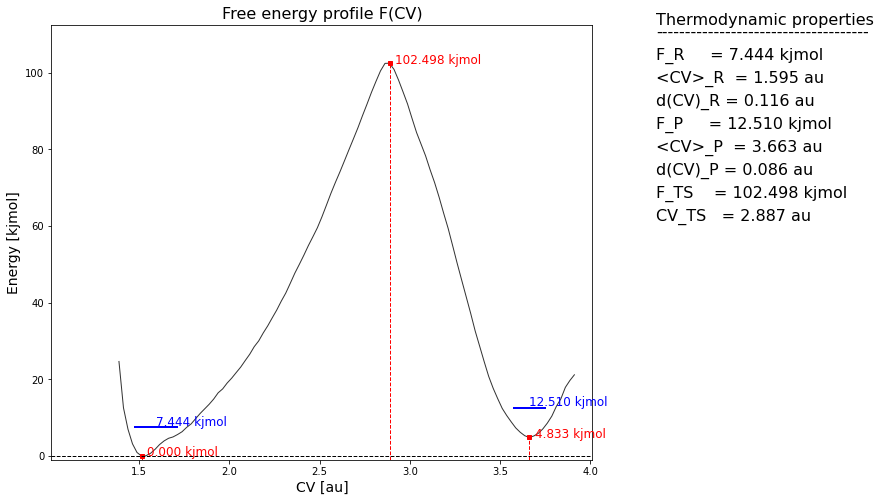

In [10]:
fep_cv1_bis = fes.project_function(function, cvs, return_class=SimpleFreeEnergyProfile)
fep_cv1_bis.process_states(lims=[-np.inf,2.4,3.0,np.inf])
fep_cv1_bis.set_ref(ref='r')
fep_cv1_bis.plot(prefix+'fep_cv1_bis.png')

As expected, we get exactly the same result.

### More exotic projection direction

Now, we go on to a more exotic direction of projection:

$f(CV_1,CV_2) = \sqrt{(CV1-1.6)^2 + (CV2+1.4)^2} - \sqrt{(CV1-3.6)^2 + (CV2+0.8)^2}$

which could be interpreted as the difference in 'distance' between the reactant and product state.

In [35]:
def function(cv1,cv2):
    dR = np.sqrt((cv1-1.6)**2 + (cv2+1.2)**2)
    dP = np.sqrt((cv1-3.6)**2 + (cv2+0.8)**2)
    return dR-dP

You can always visualize the projection direction by plotting the contours of the chosen function $f(CV_1,CV_2)$ on top of the 2D FES.

<Figure size 432x288 with 0 Axes>

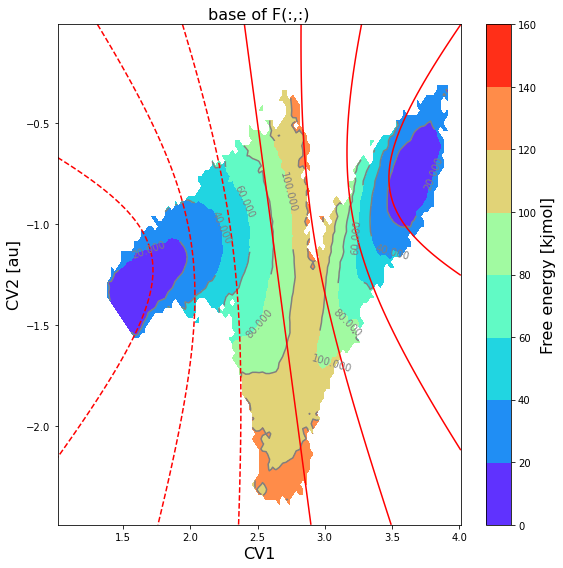

In [36]:
fes.plot(prefix+'fes_with_contour.png', plot_additional_function_contours=[function, [-2.0, -1.5, -0.5, 0, 0.5, 1.5, 2.0]], cmap='rainbow')

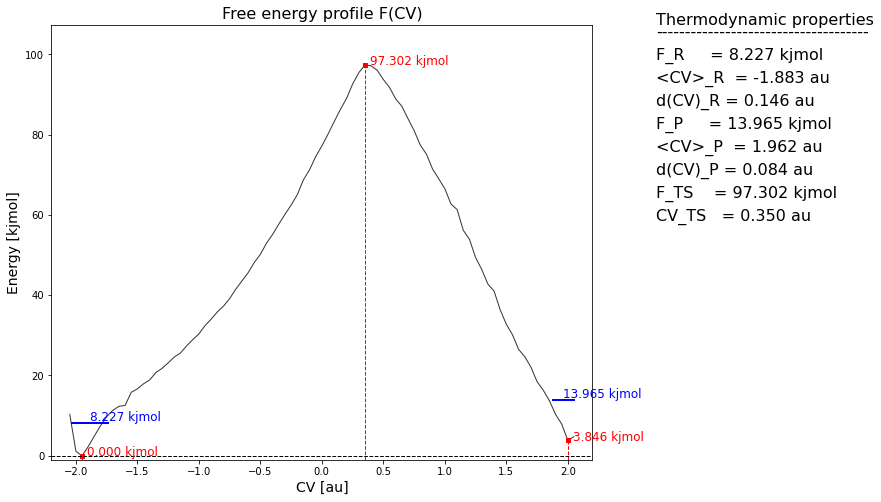

In [37]:
fep_fun = fes.project_function(function, np.arange(-2.20,2.25,0.05), delta=0.05, return_class=SimpleFreeEnergyProfile)
fep_fun.process_states(lims=[-np.inf,0.0,1.0,np.inf])
fep_fun.set_ref(ref='r')
fep_fun.plot(prefix+'fep_fun.png')

# With error estimate

We can now redo the above procedure of construction of the 2D FES and projection onto CV1 including and MLE-F error estimation. However, we therefore, first require the correlation times.

/home/louis/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 432x288 with 0 Axes>

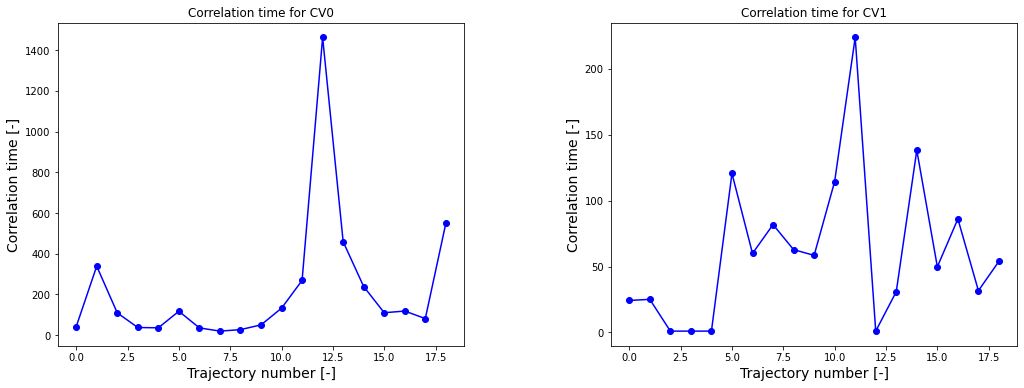

In [38]:
corrtimes_2d = decorrelate(trajectories, fn_plot=prefix+'corr_time_2d.png')

In [39]:
bins = [np.arange(1,4.025,0.025), np.arange(-2.5,0.025,0.025)]
hist_err = Histogram2D.from_wham(bins, trajectories, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes_2d, Nscf=10000, error_p_threshold=0.0001, verbosity='medium')

Initialization ...
Constructing individual histograms for each biased simulation ...
Computing bias on grid ...
Solving WHAM equations (SCF loop) ...
  SCF Converged!
Estimating error ...
  initializing ...
  computing extended Fisher matrix ...
  defining and applying zero-mask ...
  computing inverse of masked flattened Fisher matrix ...
  constructing error bars ...

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.001s
  histograms  : 00h 00m 00.029s
  bias poten. : 00h 00m 02.119s
  solve scf   : 00h 00m 00.968s
  error est.  : 00h 00m 11.776s
  TOTAL       : 00h 00m 14.893s
---------------------------------------------------------------------


/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values = self.error.nsigma_conf_int(2)[0][slicer]
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values = self.fs[slicer].copy()
/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:1472: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(s

<Figure size 432x288 with 0 Axes>

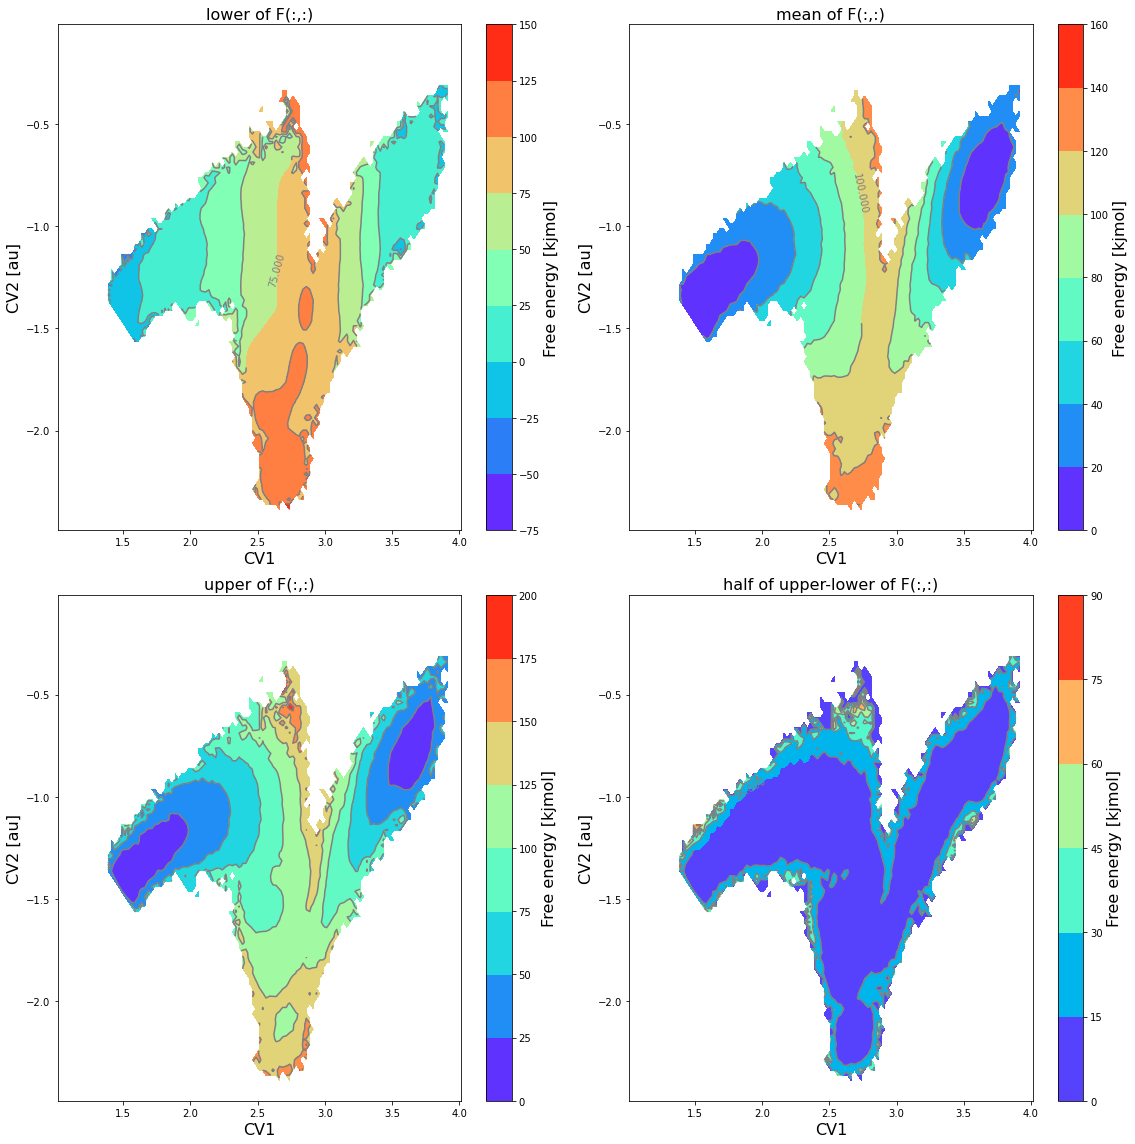

In [40]:
fes_err = FreeEnergySurface2D.from_histogram(hist_err, temp)
fes_err.set_ref(ref='min')
fes_err.plot(prefix+'fes_with_error.png', obss=['lower', 'mean', 'upper', 'half of upper-lower'], cmap='rainbow')

In [41]:
fep_cv1_err = fes_err.project_cv1(return_class=SimpleFreeEnergyProfile)

In [42]:
fep_cv1_err.process_states(lims=[-np.inf,2.6,3.0,np.inf])
fep_cv1_err.set_ref(ref='r')

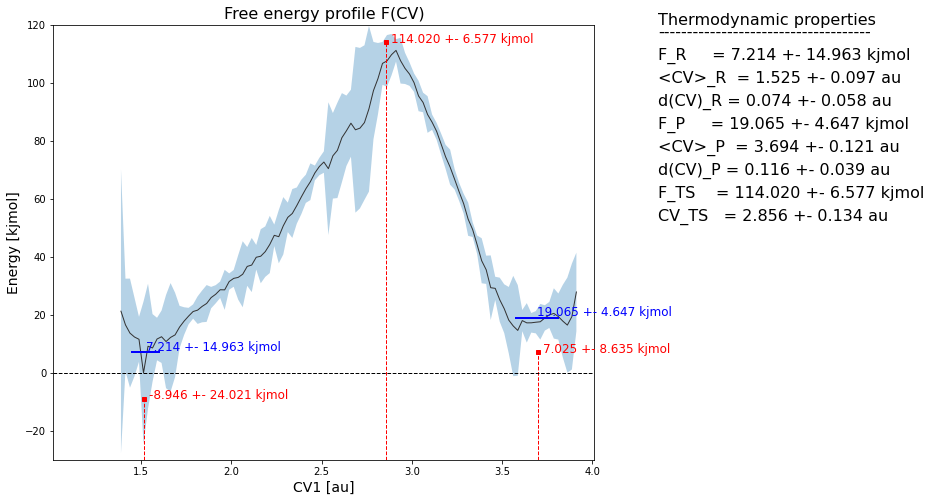

In [43]:
fep_cv1_err.plot(prefix+'fep_cv1_with_error.png', flims=[-30,120])

This last step (projection, processing states) takes some more time now because of the error propagation that is requires. Furthermore, we see that error on the 1D FEP is relatively large and more peculiar, the microstates for the reactant and product minima (the red squares on the graph on the bottom left and right) have a particular large error bar and fall on the edge (reactant) or even outside (product) the error bar of the profile. This is because various random profiles of the FEP give rise to minima at largely varying positions, which could be understood in terms of multiple large yet separated downward spikes in the FEP error. For example in the product state, we have to spikes going down all the way to 0 kjmol, one at approx 3.55 and one at approx 3.9. So upon taking random samples of the FEP (which is done for error propagation of the FEP error towards the microstate minima and maxima errors), there will be some of them with a min at 3.55 and some of them at a 3.9, which on average will give rise to a minimum located in between.